In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [13]:
df = pd.read_csv("BTC-USD.csv")

In [14]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [15]:
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

In [16]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close).reshape(-1, 1))

In [17]:
# Chia dữ liệu thành tập train và test dataset
train_size = int(0.6 * len(data_scaled))
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]


In [18]:
pip install blosc2~=2.0.0

In [19]:
!pip install pmdarima

In [20]:
# Chuyển đổi định dạng dữ liệu cho auto_arima
y_train = train_data.flatten()

In [21]:
# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6081.318, Time=3.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6088.360, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6087.426, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6087.435, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6089.538, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6085.438, Time=1.46 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 7.160 seconds


In [22]:
# Fit the model
model.fit(y_train)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [23]:
# Dự đoán trên tập test
y_test = test_data.flatten()
y_pred = model.predict(n_periods=len(y_test))

In [24]:
# Chuyển đổi dữ liệu dự đoán và dữ liệu thực tế về tỷ lệ gốc
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1))

In [25]:
# Tính toán các độ đo sai lệch
test_mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)
test_mse = mean_squared_error(y_test_inverse, y_pred_inverse)
test_rmse = np.sqrt(test_mse)

print(f"MAPE on Test dataset: {test_mape}")
print(f"RMSE on Test dataset: {test_rmse}")
print(f"MSE on Test dataset: {test_mse}")

MAPE on Test dataset: 0.5780628840797075
RMSE on Test dataset: 16932.245880478
MSE on Test dataset: 286700950.5569642


Predicting the next 30 days

In [26]:
# Dự đoán 30, 60, 90 ngày tiếp theo từ 1/6
forecast_30_days = model.predict(n_periods=30)
forecast_60_days = model.predict(n_periods=60)
forecast_90_days = model.predict(n_periods=90)

In [27]:
# Chuyển đổi dự đoán về tỷ lệ gốc
forecast_30_days_inverse = scaler.inverse_transform(forecast_30_days.reshape(-1, 1))
forecast_60_days_inverse = scaler.inverse_transform(forecast_60_days.reshape(-1, 1))
forecast_90_days_inverse = scaler.inverse_transform(forecast_90_days.reshape(-1, 1))

In [28]:
print('Predicted closing prices for the next 30 days:')
print(forecast_30_days_inverse.flatten())

print('Predicted closing prices for the next 60 days:')
print(forecast_60_days_inverse.flatten())

print('Predicted closing prices for the next 90 days:')
print(forecast_90_days_inverse.flatten())

Predicted closing prices for the next 30 days:
[40458.308594 40458.308594 40458.308594 40458.308594 40458.308594
 40458.308594 40458.308594 40458.308594 40458.308594 40458.308594
 40458.308594 40458.308594 40458.308594 40458.308594 40458.308594
 40458.308594 40458.308594 40458.308594 40458.308594 40458.308594
 40458.308594 40458.308594 40458.308594 40458.308594 40458.308594
 40458.308594 40458.308594 40458.308594 40458.308594 40458.308594]
Predicted closing prices for the next 60 days:
[40458.308594 40458.308594 40458.308594 40458.308594 40458.308594
 40458.308594 40458.308594 40458.308594 40458.308594 40458.308594
 40458.308594 40458.308594 40458.308594 40458.308594 40458.308594
 40458.308594 40458.308594 40458.308594 40458.308594 40458.308594
 40458.308594 40458.308594 40458.308594 40458.308594 40458.308594
 40458.308594 40458.308594 40458.308594 40458.308594 40458.308594
 40458.308594 40458.308594 40458.308594 40458.308594 40458.308594
 40458.308594 40458.308594 40458.308594 40458.3

In [29]:
# Tạo index cho các dự đoán tiếp theo
last_date = df.index[-1]
index_next_30_days = pd.date_range(last_date + pd.Timedelta(days=1), periods=30, freq='D')
index_next_60_days = pd.date_range(last_date + pd.Timedelta(days=1), periods=60, freq='D')
index_next_90_days = pd.date_range(last_date + pd.Timedelta(days=1), periods=90, freq='D')


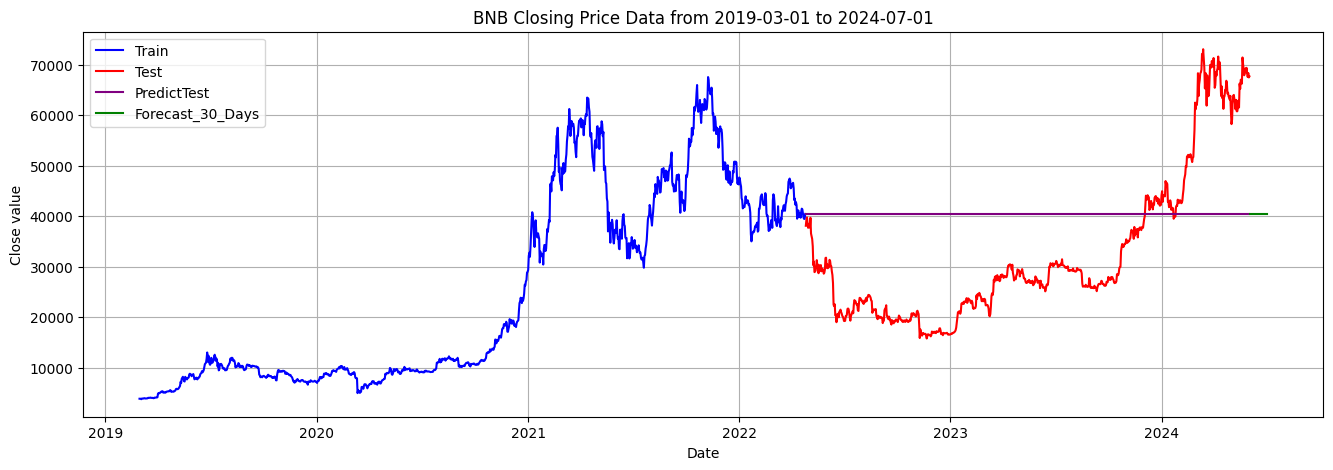

In [30]:
# Vẽ đồ thị cho dự đoán 30 ngày
plt.figure(figsize=(16, 5))
plt.plot(df.index[:train_size], scaler.inverse_transform(train_data), color='blue', linestyle='-', label='Train')
plt.plot(df.index[train_size:train_size + len(y_test)], y_test_inverse, color='red', linestyle='-', label='Test')
plt.plot(df.index[train_size:train_size + len(y_test)], y_pred_inverse, color='purple', linestyle='-', label='PredictTest')
plt.plot(index_next_30_days, forecast_30_days_inverse, color='green', linestyle='-', label='Forecast_30_Days')
plt.legend()
plt.grid()
plt.title(f"BNB Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('ARIMA_BTC_30days.png')
plt.show()

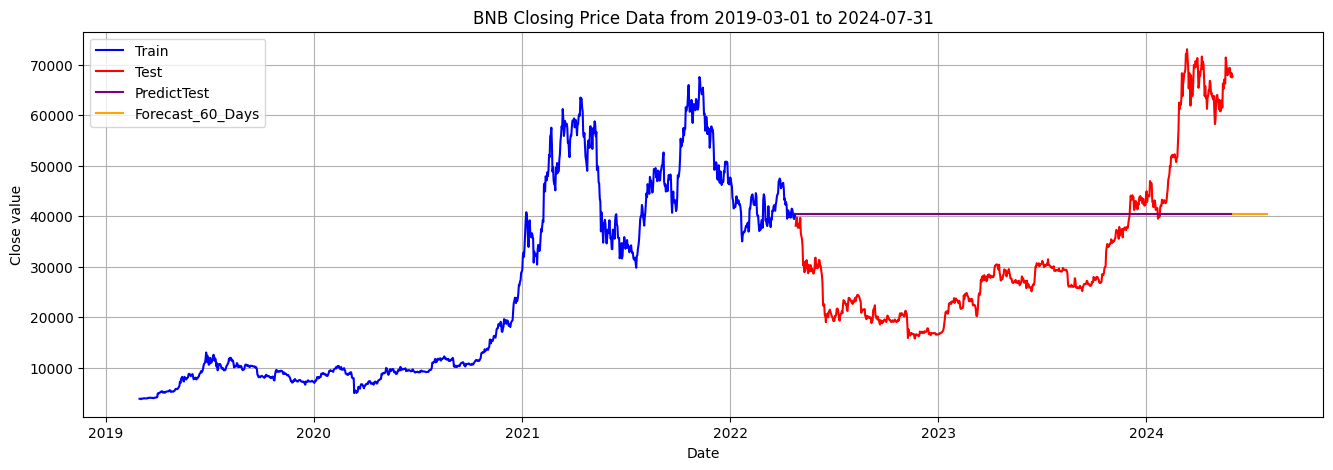

In [31]:
# Vẽ đồ thị cho dự đoán 60 ngày
plt.figure(figsize=(16, 5))
plt.plot(df.index[:train_size], scaler.inverse_transform(train_data), color='blue', linestyle='-', label='Train')
plt.plot(df.index[train_size:train_size + len(y_test)], y_test_inverse, color='red', linestyle='-', label='Test')
plt.plot(df.index[train_size:train_size + len(y_test)], y_pred_inverse, color='purple', linestyle='-', label='PredictTest')
plt.plot(index_next_60_days, forecast_60_days_inverse[:60], color='orange', linestyle='-', label='Forecast_60_Days')
plt.legend()
plt.grid()
plt.title(f"BNB Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_60_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('ARIMA_BTC_60days.png')
plt.show()


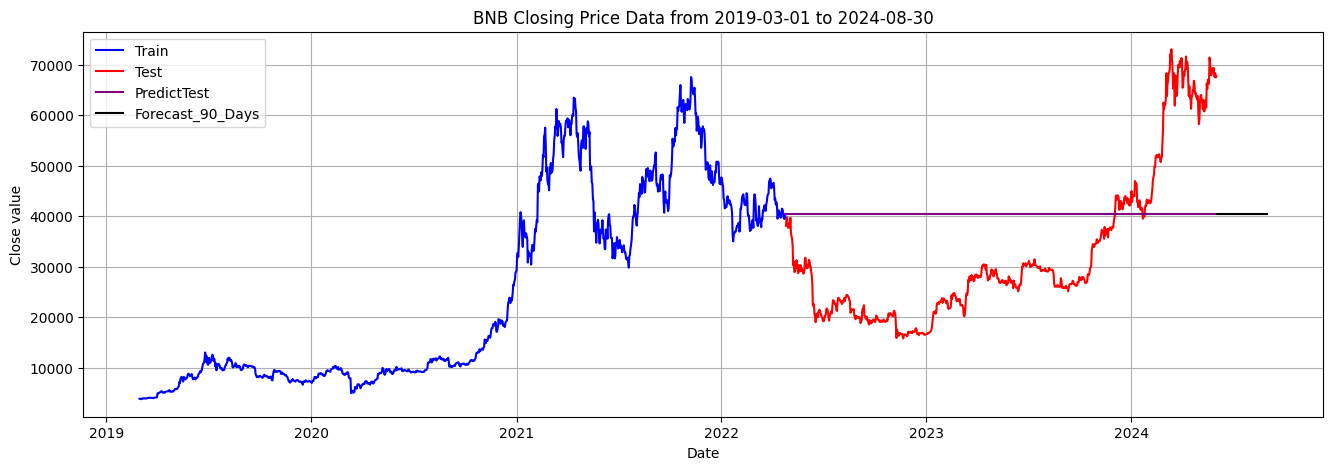

In [32]:
# Vẽ đồ thị cho dự đoán 90 ngày
plt.figure(figsize=(16, 5))
plt.plot(df.index[:train_size], scaler.inverse_transform(train_data), color='blue', linestyle='-', label='Train')
plt.plot(df.index[train_size:train_size + len(y_test)], y_test_inverse, color='red', linestyle='-', label='Test')
plt.plot(df.index[train_size:train_size + len(y_test)], y_pred_inverse, color='purple', linestyle='-', label='PredictTest')
plt.plot(index_next_90_days, forecast_90_days_inverse[:90], color='black', linestyle='-', label='Forecast_90_Days')
plt.legend()
plt.grid()
plt.title(f"BNB Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_90_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('ARIMA_BTC_90days.png')
plt.show()